In [3]:
from keras.models import load_model
import numpy as np
import os
import cv2
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from patchify import patchify
from PIL import Image
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from PIL import Image
from patchify import patchify, unpatchify
import math

In [4]:
model=load_model('unet_Seagrass.hdf5')

In [5]:
seed = 24
batch = 10
test_images=[]
test_masks=[]
pre_images=[]
path_test_images =  r"PATCH_DATA\test_images\test\\"
path_test_masks =  r"PATCH_DATA\test_masks\test\\" 
for image in os.listdir(path_test_images):
    img = cv2.imread(path_test_images + image)
    msk =  cv2.threshold(cv2.imread(path_test_masks + image,0), 0, 1, cv2.THRESH_BINARY)[1]
    test_images.append(np.expand_dims(img, 0))
    test_masks.append(msk)
    pre_images.append((model.predict(np.expand_dims(img/255,0),verbose=0)[0,:,:,0] > 0.6).astype(np.uint8))  

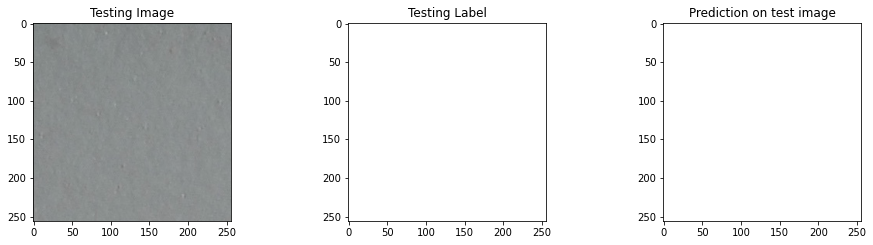

In [6]:
#checking the masks and predicted masks
x=5
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_images[x][0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_masks[x]*255, cmap='gray', vmin=0,vmax=255)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(pre_images[x]*255, cmap='gray', vmin=0,vmax=255)
plt.show()

In [7]:
#Computing accuracy on the test set
print("Accuracy on the test dataset: " + str(np.asarray([metrics.accuracy_score(test_masks[k].reshape(-1), pre_images[k].reshape(-1)) for k in range(len(test_masks))]).sum()/len(test_masks)))

Accuracy on the test dataset: 0.8897142039816599


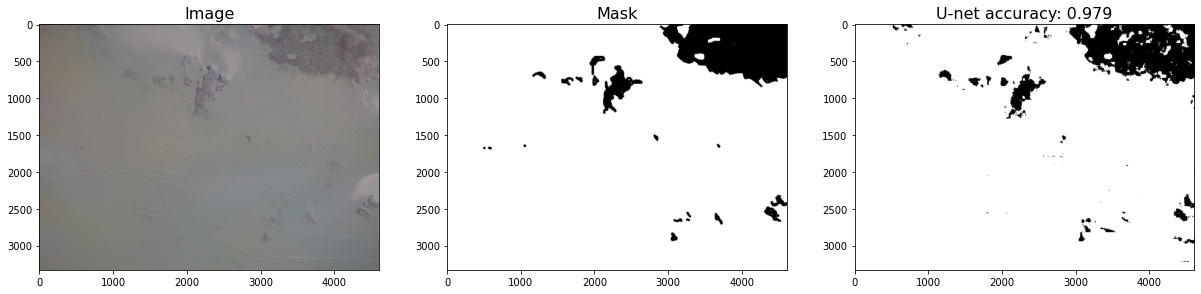

In [9]:
# Predicting on the original image sizes
path_images =  r"dataset\\"
path_masks =  r"masks\\" 
# Choosing an image
image = "DJI_0011.jpg"
img = cv2.imread(path_images + image)
msk = cv2.threshold(cv2.imread(path_masks + image,0), 0, 1, cv2.THRESH_BINARY)[1]

patch_size = 256
########################
#Predict patch by patch 
########################

SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
large_img = np.array(large_img) 

large_msk = Image.fromarray(msk)
large_msk = large_msk.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
large_msk = np.array(large_msk) 

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        pred = (model.predict(np.expand_dims(single_patch_img/255,0),verbose=0)[0,:,:,0] > 0.6).astype(np.uint8)
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

plt.figure(figsize=(28, 24))
plt.subplot(241)
plt.title('Image',fontsize=16)
plt.imshow(large_img)
plt.subplot(242)
plt.title('Mask',fontsize=16)
plt.imshow(large_msk*255, cmap='gray', vmin=0,vmax=255)
plt.subplot(243)
plt.title('U-net accuracy: '+ str(round(metrics.accuracy_score(large_msk.reshape(-1), unpatched_prediction.reshape(-1)),3)), fontsize=16)
plt.imshow(unpatched_prediction*255, cmap='gray', vmin=0,vmax=255)
plt.show()


In [ ]:
# postprocessing on the predicted labels

0.9613959809653779 3


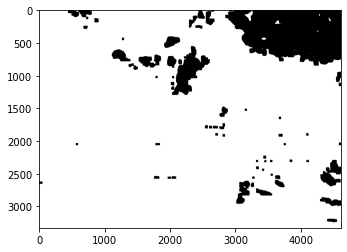

In [11]:
k=33
erosion = cv2.erode(unpatched_prediction, np.ones((k, k))) 
plt.imshow(erosion,"gray")
print(metrics.accuracy_score(large_msk.reshape(-1), erosion.reshape(-1)),3)

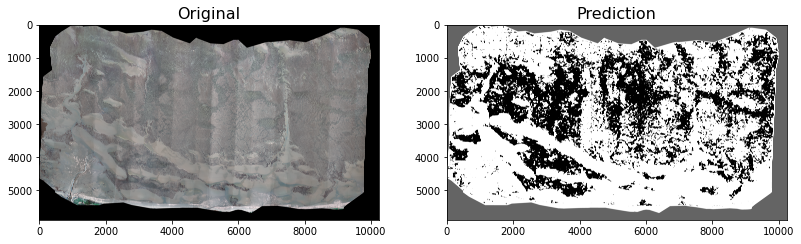

In [205]:
# predicting on ARC_orthophotos
model=load_model('unet_Seagrass.hdf5')
patch_size = 256
img = cv2.imread(r"ARC_orthophotos\snellsBeach_orthophoto.tif")

zx = img.shape[0]//256*256+256-img.shape[0]
zy = img.shape[1]//256*256+256-img.shape[1]
image = np.concatenate((img,np.zeros((zx,img.shape[1],3),dtype=np.uint8)))
image = np.concatenate((image,np.zeros((image.shape[0],zy,3),dtype=np.uint8)),axis=1)
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        pred = (model.predict(np.expand_dims(single_patch_img/255,0),verbose=0)[0,:,:,0] > 0.6).astype(np.uint8)
        patched_prediction.append(pred)
        
patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], patches_img.shape[2], patches_img.shape[3]])
result = unpatchify(patched_prediction, (image.shape[0], image.shape[1]))
result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)*255
result[image==[0, 0, 0]]=100
# cv2.imwrite(r"ARC_orthophotos\Predict_snellsBeach.tif", result)
plt.figure(figsize=(28, 24))
plt.subplot(241)
plt.title('Original',fontsize=16)
plt.imshow(image)
plt.subplot(242)
plt.title('Prediction',fontsize=16)
plt.imshow(result)
plt.show()